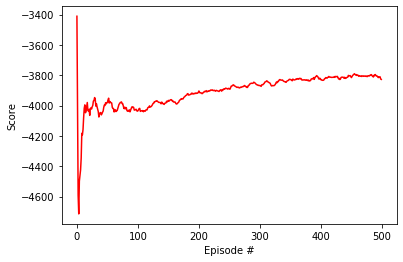

Episode 500	Average Score: -3827.53	Best Score: -3827.53


/home/shadowwalker/anaconda3/envs/RIL/lib/python3.7/site-packages/torch/tensor.py:293: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
from torch import nn
import torch.nn.functional as F
import sys

sys.path.append("/media/shadowwalker/DATA/study/RIL1/code/carmanufacturing/model")
from environment import Environment
from dgnAgent import Agent
from trainer import Trainer
from wrapper import MultiAgentWrapper as MAW
from wrapper import SingleAgentWrapper as SAW
from wrapper import CrossProductWrapper as CPW
import functions as fc
# Constants
KIND_CARS = 8
INPUT_SEQUENCE_LENGTH = 100
INPUT_WINDOW = 3
OUTPUT_SEQUENCE_LENGTH = 4
NUM_LINES = 4
CAPACITY_LINES = 3


# Constants Agent
BUFFER_SIZE = int(1e7)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 1          # discount factor
TAU = 0.001#1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network
SEED = 0

initial_ratio = 0.6

# define neural network
class Network(nn.Module):
    def __init__(self, layer_numbers):
        super().__init__()
        self.fc1 = nn.Linear(layer_numbers[0], layer_numbers[1])
        self.fc2 = nn.Linear(layer_numbers[1], layer_numbers[2])
        self.fc3 = nn.Linear(layer_numbers[2], layer_numbers[3])
        self.fc4 = nn.Linear(layer_numbers[3], layer_numbers[4])
        # self.fc6 = nn.Linear(layer_numbers[5], layer_numbers[6])


    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        # x = F.relu(x)
        # x = self.fc6(x)
        return x

#don't change this!
for i in [7]:
    INPUT_WINDOW = i
    # important for network specific stuff
    layers = [(INPUT_WINDOW + OUTPUT_SEQUENCE_LENGTH+NUM_LINES*CAPACITY_LINES)*(KIND_CARS+1),128,128,128,NUM_LINES*NUM_LINES]
    net = Network(layers)
    # create name
    name = 'CP_I:' + str(INPUT_WINDOW) + "_O:" + str(OUTPUT_SEQUENCE_LENGTH) + "_N:"
    for layer in layers:
       name += str(layer) + "-"
    name = name[:-1]
    name += "_NL:" + str(NUM_LINES) + "_CL:" + str(CAPACITY_LINES) + "_W:" + str(INPUT_SEQUENCE_LENGTH) + "_KC:" + str(KIND_CARS)
    # initialize training


    env = Environment(INPUT_SEQUENCE_LENGTH, KIND_CARS, NUM_LINES, CAPACITY_LINES, OUTPUT_SEQUENCE_LENGTH, INPUT_WINDOW, 0, initial_ratio = initial_ratio)
    cpw = CPW(env)
    agent = Agent(net, BUFFER_SIZE, BATCH_SIZE, UPDATE_EVERY, GAMMA, TAU, LR, SEED)
    trainer = Trainer(name, KIND_CARS, GAMMA)
    # train and return scores. agent will be trained afterwards
    scores = trainer.train(cpw, agent, 250, n_episodes=50000, eps_start=1.0, eps_end=0.001, eps_decay=0.9998, show_picture= True, valid_actions_only = False)

